In [2]:
# Import the required packages

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
#import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter
import itertools


In [3]:
#Set up plotting themes
sns.set_context('poster')
sns.set_style('darkgrid')

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [4]:
# data = pd.read_csv('data/240010_eb_music_2010-09-21_02h04.06.427.csv')

In [5]:
# list(data.columns)

In [6]:
def clean_data(filename, type = 'exposure'):
    # print(filename)
    # Handle errors. If there is an error, go to 'except' and return nothing.
    data = pd.read_csv('data/' + filename)
    
    if type == 'exposure':
        try:
    
            # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
            data = data.dropna(subset=['blocks.thisRepN']).reset_index(drop=True)
    
            #If data file is incomplete, raise an error. 
            if sum(data['node idx'].notna()) < 1400:
                raise TypeError('Incomplete Data')
    
    
            #Rt is average rt of all keys pressed
            data['rt'] = [np.mean(ast.literal_eval(data['key_resp.rt'][i])) if data['accuracy'][i] else np.NaN for i in range(len(data))]
            
            #Transition type is cross cluster if goes from boundary to boundary
            data['transition_type'] = ['cross cluster' if (data['node type'] == 'boundary')[i] & (data['node type'].shift() == 'boundary')[i] else 'within cluster' for i in range(len(data))]
    
            #Label conditions based on participant number as was designed in the experiment
            if data['participant'][0]%3 == 0:
                data['condition'] = 'random'
            elif data['participant'][0]%3 == 1:
                data['condition'] = 'music random'
            else:
                data['condition'] = 'structured'
    
            data['trial'] = np.arange(len(data))
            return data[['participant', 'trial', 'blocks.thisRepN', 'accuracy', 'condition', 'node type', 'transition_type', 'rt', 'stim']]
        except:
            return None
    else:
        try:
            mem_data = data.loc[data['mem test stim'].notna(), ['mem test stim', 'mem test resp']].reset_index(drop=True)
            mem_data.rename(columns={'mem test stim': 'stim'}, inplace=True)
            
            music_stim = []
            corr_key_resp = []
            node_id = []
            stim_key_map = {}
            for ms in data['selected music stim'].unique():
                if ms is np.NaN:
                    continue
                music_stim.append(ms[16:])
                corr_key_resp.append(data.loc[data['selected music stim'] == ms, 'stim'].unique()[0])    
                stim_key_map[ms[16:]] = data.loc[data['selected music stim'] == ms, 'stim'].unique()
                node_id.append(data.loc[data['selected music stim'] == ms, 'node type'].unique()[0])    
            
            stim_key_df = pd.DataFrame({'stim': music_stim, 
                                        'corr key resp': corr_key_resp,
                                        'node type': node_id
                                       })
            
            
            memory = mem_data.merge(stim_key_df, on=['stim'])
            memory['accuracy'] = [ast.literal_eval(memory['corr key resp'][i]) == tuple(ast.literal_eval(memory['mem test resp'][i])) for i in range(len(memory))]
            memory['participant'] = data['participant'][0]
    
            if memory['participant'][0]%3 == 0:
                memory['condition'] = 'random'
            elif memory['participant'][0]%3 == 1:
                memory['condition'] = 'music random'
            else:
                memory['condition'] = 'structured'
    
            return memory
        except:
            return None
    # except:
    #     return None

    # #Count the number of keys to be pressed for each stimuli
    # data['num_keypress'] = [len(ast.literal_eval(data['stim'][i])) for i in range(len(data))]


    
    # #Return the dataframe with relevant columns
    # if type == 'exposure:


# Read the data files

In [7]:
#reads in all the NAMES of the data files from the 'data' folder. 
data_files = []
for f in os.listdir('data/'):
    if (f.startswith('240') & f.endswith('csv')):
        data_files.append(f)

# Sanity Check 1 
Print out the data_files variable and test if correct files are being loaded

In [26]:
data_files

['240000_eb_music_2024-03-13_13h32.51.559.csv',
 '240001_eb_music_2024-03-13_13h28.21.687.csv',
 '240003_eb_music_2024-03-14_12h29.04.605.csv',
 '240004_eb_music_2024-03-14_12h59.27.819.csv',
 '240005_eb_music_2010-09-20_02h29.21.924.csv',
 '240006_eb_music_2010-09-21_01h01.38.600.csv',
 '240007_eb_music_2024-03-15_11h40.37.731.csv',
 '240008_eb_music_2024-03-15_12h02.14.101.csv',
 '240009_eb_music_2024-03-15_12h47.17.042.csv',
 '240010_eb_music_2010-09-21_02h04.06.427.csv',
 '240011_eb_music_2010-10-01_01h53.02.852.csv',
 '240012_eb_music_2024-03-25_12h29.30.924.csv',
 '240013_eb_music_2024-03-25_12h49.02.447.csv',
 '240014_eb_music_2010-10-01_02h46.04.024.csv',
 '240015_eb_music_2024-03-27_11h23.41.504.csv',
 '240016_eb_music_2010-10-03_00h47.33.136.csv',
 '240017_eb_music_2024-03-27_12h53.21.987.csv',
 '240018_eb_music_2024-03-27_13h18.21.516.csv',
 '240019_eb_music_2010-10-04_01h39.43.870.csv',
 '240020_eb_music_2024-03-28_12h16.20.572.csv',
 '240021_eb_music_2024-03-28_12h37.06.19

# Cleaning the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [8]:
df_clean = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)
df_clean_memory = pd.concat([clean_data(f, 'memory') for f in data_files]).reset_index(drop = True)

# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'blocks.thisRepN', 'condition', 'node type', 'transition_type']).median(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

In [9]:
df_clean_memory

,stim,mem test resp,corr key resp,node type,accuracy,participant,condition
0,0205 C+.wav,"['h', 'k']","('j', 'l')",non boundary,False,240000.0,random
1,1002 A.wav,"['l', 'space']","('space',)",boundary,False,240000.0,random
2,1005 A.wav,"['k', 'space']","('k', 'l')",non boundary,False,240000.0,random
3,1004 A.wav,"['h', 'j']","('h', 'l')",non boundary,False,240000.0,random
4,0603 F.wav,['j'],"('l',)",boundary,False,240000.0,random
...,...,...,...,...,...,...,...
610,0601 F.wav,['k'],"('j', 'k')",boundary,False,240042.0,random
611,0204 C+.wav,['l'],"('l', 'space')",boundary,False,240042.0,random
612,0205 C+.wav,"['j', 'k']","('j',)",non boundary,False,240042.0,random
613,1004 A.wav,"['l', 'h']","('l',)",non boundary,False,240042.0,random


# Sanity Check 2
Print out the dataframe df_clearn_rt_outlier to see if it looks as expected. 

Take a note of the relevant columns

In [9]:
df_clean_rt_outlier

,participant,trial,blocks.thisRepN,accuracy,condition,node type,transition_type,rt,stim
0,240000.0,0,0.0,1.0,random,non boundary,within cluster,1.471844,"('j',)"
1,240000.0,1,0.0,1.0,random,non boundary,within cluster,0.459337,"('j',)"
2,240000.0,2,0.0,1.0,random,boundary,within cluster,0.423757,"('l',)"
3,240000.0,3,0.0,1.0,random,non boundary,within cluster,0.669688,"('j', 'space')"
4,240000.0,4,0.0,1.0,random,non boundary,within cluster,1.228632,"('j', 'l')"
...,...,...,...,...,...,...,...,...,...
57395,240042.0,1395,6.0,1.0,random,non boundary,within cluster,0.524434,"('j', 'l')"
57396,240042.0,1396,6.0,1.0,random,non boundary,within cluster,0.595624,"('j',)"
57397,240042.0,1397,6.0,1.0,random,non boundary,within cluster,0.983133,"('h', 'k')"
57398,240042.0,1398,6.0,1.0,random,boundary,within cluster,0.654413,"('l', 'space')"


In [11]:
df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node type']+'_'+df_clean_rt_outlier['transition_type']
df_clean_participant['node_transition_type']=df_clean_participant['node type']+'_'+df_clean_participant['transition_type']


In [11]:
df_clean_rt_outlier

,participant,trial,blocks.thisRepN,accuracy,condition,node type,transition_type,rt,stim,node_transition_type
0,240000.0,0,0.0,1.0,random,non boundary,within cluster,1.471844,"('j',)",non boundary_within cluster
1,240000.0,1,0.0,1.0,random,non boundary,within cluster,0.459337,"('j',)",non boundary_within cluster
2,240000.0,2,0.0,1.0,random,boundary,within cluster,0.423757,"('l',)",boundary_within cluster
3,240000.0,3,0.0,1.0,random,non boundary,within cluster,0.669688,"('j', 'space')",non boundary_within cluster
4,240000.0,4,0.0,1.0,random,non boundary,within cluster,1.228632,"('j', 'l')",non boundary_within cluster
...,...,...,...,...,...,...,...,...,...,...
57395,240042.0,1395,6.0,1.0,random,non boundary,within cluster,0.524434,"('j', 'l')",non boundary_within cluster
57396,240042.0,1396,6.0,1.0,random,non boundary,within cluster,0.595624,"('j',)",non boundary_within cluster
57397,240042.0,1397,6.0,1.0,random,non boundary,within cluster,0.983133,"('h', 'k')",non boundary_within cluster
57398,240042.0,1398,6.0,1.0,random,boundary,within cluster,0.654413,"('l', 'space')",boundary_within cluster


# Plot RTs
The dataframe that is created above (df_clearn_rt_outlier) removes outliers where people may have responded too quickly or too slowly. This is the dataframe we want to work with. Let's start by plotting first. 

Plot a graph using python's seaborn package such that: 
1. The Y axis is the average response time
2. The X axis is the block number
3. The graph has three 'column' panels corresponding to the three conditions.


(Hint: Use the seaborn catplot function)

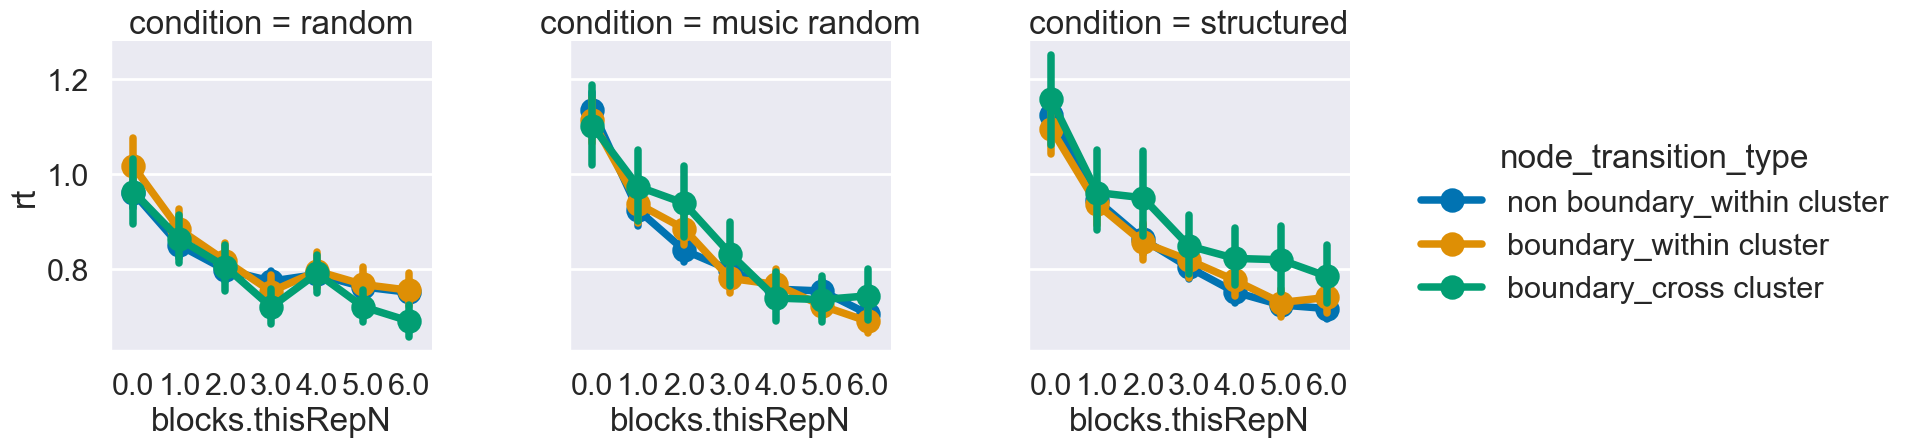

In [18]:
sns.catplot(data=df_clean_rt_outlier, y='rt', x='blocks.thisRepN', hue='node_transition_type', row=None, col='condition', 
            kind='point', margin_titles=True, estimator='mean', seed=42,
           palette=sns.color_palette("colorblind"))


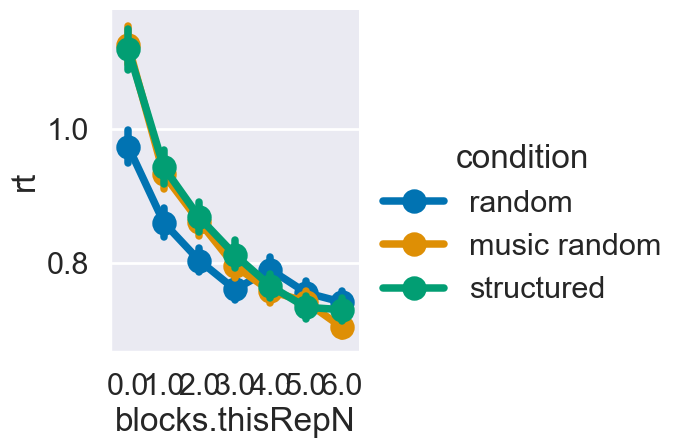

In [46]:
sns.catplot(data=df_clean_rt_outlier, y='rt', x='blocks.thisRepN', hue='condition', row=None, 
            kind='point', margin_titles=True, estimator='mean', seed=0,
           palette=sns.color_palette("colorblind"))


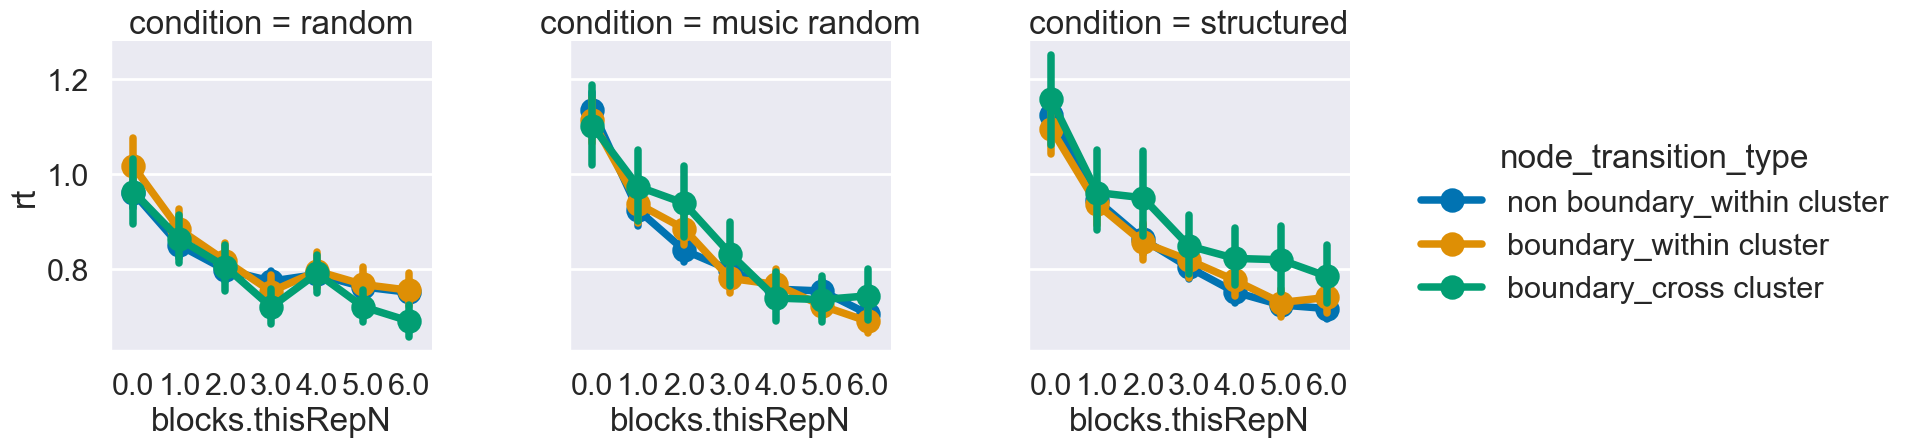

In [54]:
sns.catplot(data=df_clean_rt_outlier, y='rt', x='blocks.thisRepN', hue='node_transition_type', row=None, col='condition', 
            kind='point', margin_titles=True, estimator='mean', seed=42,
           palette=sns.color_palette("colorblind"))


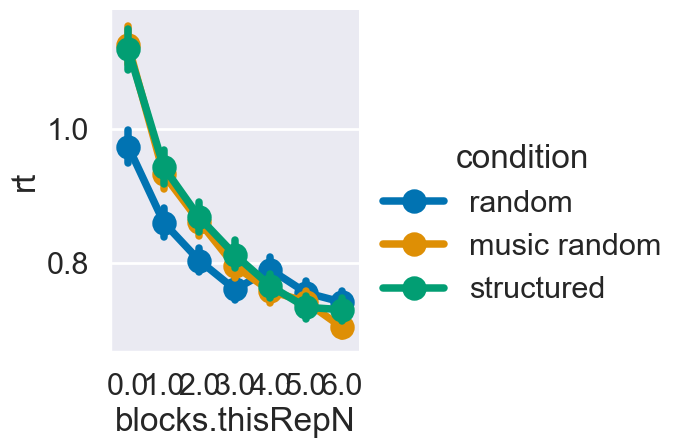

In [55]:
sns.catplot(data=df_clean_rt_outlier, y='rt', x='blocks.thisRepN', hue='condition', row=None, 
            kind='point', margin_titles=True, estimator='mean', seed=0,
           palette=sns.color_palette("colorblind"))


# Plot Accuracies
That dataframe also has a column called 'accuracy'. Use that colum to plot a graph using python's seaborn package such that: 
1. The Y axis is the average accuracy
2. The X axis is the block number
3. The graph has three 'column' panels corresponding to the three conditions. 

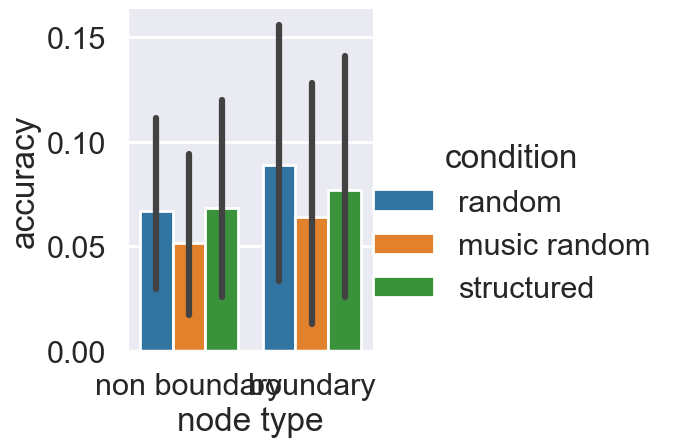

In [16]:
sns.catplot(data=df_clean_memory, y='accuracy', x='node type', hue='condition', kind = 'bar', estimator='mean')

In [12]:
df_clean_rt_outlier

,participant,trial,blocks.thisRepN,accuracy,condition,node type,transition_type,rt,stim,node_transition_type
0,240000.0,0,0.0,1.0,random,non boundary,within cluster,1.471844,"('j',)",non boundary_within cluster
1,240000.0,1,0.0,1.0,random,non boundary,within cluster,0.459337,"('j',)",non boundary_within cluster
2,240000.0,2,0.0,1.0,random,boundary,within cluster,0.423757,"('l',)",boundary_within cluster
3,240000.0,3,0.0,1.0,random,non boundary,within cluster,0.669688,"('j', 'space')",non boundary_within cluster
4,240000.0,4,0.0,1.0,random,non boundary,within cluster,1.228632,"('j', 'l')",non boundary_within cluster
...,...,...,...,...,...,...,...,...,...,...
57395,240042.0,1395,6.0,1.0,random,non boundary,within cluster,0.524434,"('j', 'l')",non boundary_within cluster
57396,240042.0,1396,6.0,1.0,random,non boundary,within cluster,0.595624,"('j',)",non boundary_within cluster
57397,240042.0,1397,6.0,1.0,random,non boundary,within cluster,0.983133,"('h', 'k')",non boundary_within cluster
57398,240042.0,1398,6.0,1.0,random,boundary,within cluster,0.654413,"('l', 'space')",boundary_within cluster


In [1]:
import bambi as bmb

In [26]:
model = bmb.Model('rt ~ condition + (node_transition_type|participant) + (blocks.thisRepN|participant)', data = df_clean_rt_outlier)

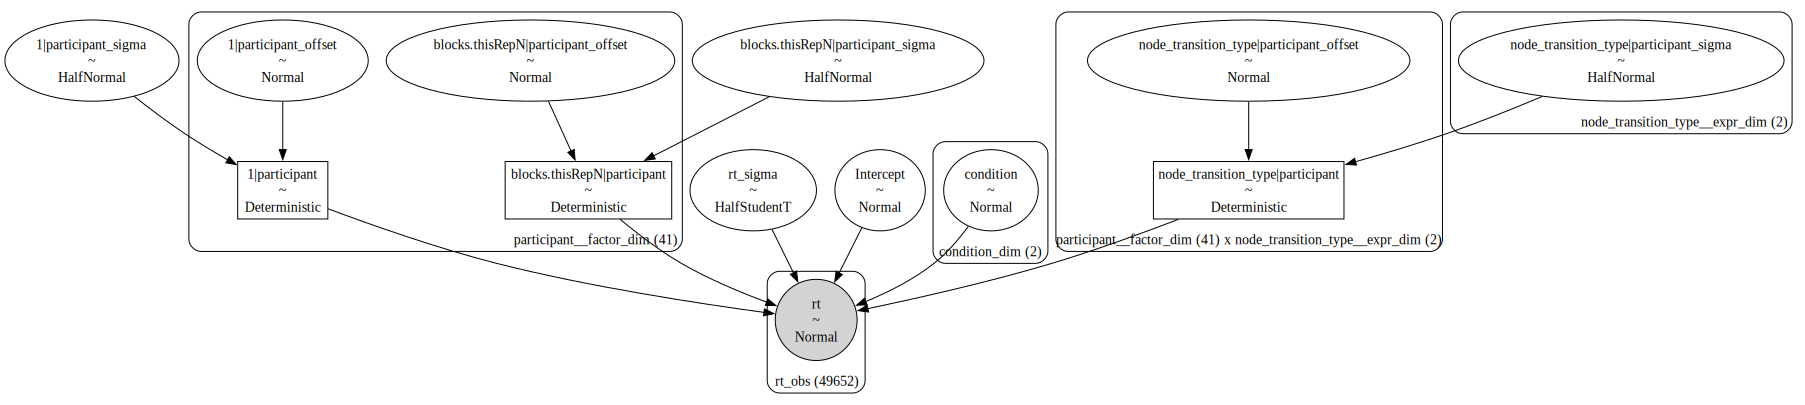

In [27]:
model.build()
model.graph()

In [28]:
model

       Formula: rt ~ condition + (node_transition_type|participant) + (blocks.thisRepN|participant)
        Family: gaussian
          Link: mu = identity
  Observations: 49652
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.8329, sigma: 1.8442)
            condition ~ Normal(mu: [0. 0.], sigma: [2.6921 2.7767])
        
        Group-level effects
            1|participant ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.8442))
            node_transition_type|participant ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: [2.8817 2.6378]))
            blocks.thisRepN|participant ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.6494))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.5174)

In [30]:
sample = model.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...

KeyboardInterrupt

